**Actor-Crictic**

1. Dựa theo  policy $\pi_{\theta}$, thực hiện một action $a$ ~ $\pi(a|s)$ để có ($s,a,s',r$)
2. Fit $V_{\theta}(s)$ với $r + V_{\theta}(s')$
3. Tính $A(s_t)=r(s_t,a_t)+\gamma V_{\theta}s_{t+1}-V_{\theta}(s_t)$ (1)
4. Tính $\nabla_{\theta}J(\theta)=\sum_i\nabla log\pi_{theta}(a_i|s_i)A^{\pi}(s_i,a_i)$
5. Update $\theta \leftarrow \theta+\alpha\nabla_{\theta}J(\theta)$

Ở đây ta sẽ dùng một mô hình đâu vào là một state của Agen được đánh dưới dạng One-hot, với các đầu ra gồm:
 * Actor là phân bố xác suất theo phân phối Categorical
 * Crictic là một chỉ số để đánh giá cho một hành động mà Actor sau khi lấy mẫu ngẫu nhiên dựa trên phân bố xác suất đã được huấn luyện

Ngoài ra ta nên lưu ý: $J(\theta)=Loss_{Actor}+Loss_{Crictic}$:
* $Loss_{Actor}=\sum_ilog \pi_{\theta}(a_i|s_i)A^{\pi}(s_i,a_i)$, VỚI i là các steps trong 1 episode, $A^{\pi}$ được gọi là Advantage tại state $s$ khi thực hiện  action $a$ được tính như công thức (1)
* $Loss_{Crictic}=HuberLoss$ 
https://en.wikipedia.org/wiki/Huber_loss


Car_Pole là một con lắc có trọng tâm nằm trên điểm quay của nó. Nó không ổn định, nhưng có thể được kiểm soát bằng cách di chuyển điểm trục xuống dưới tâm khối lượng. Mục đích là để giữ cân bằng cartpole bằng cách tác dụng các lực thích hợp lên một điểm trục.


Cột được gắn bằng một khớp  vào xe đẩy, khớp này di chuyển dọc theo đường ray. Hệ thống được điều khiển bằng cách tác dụng một lực theo hướng trái hoặc phải vào giỏ hàng. Con lắc bắt đầu thẳng đứng, và mục đích là ngăn nó rơi xuống. Phần thưởng +1 được cung cấp cho mỗi bước thời gian mà cột vẫn thẳng đứng. Tập kết thúc khi cột lệch hơn 15 độ so với phương thẳng đứng hoặc xe đẩy cách tâm hơn 2,4 đơn vị. Khi reward >195 chúng ta cũng sẽ kết thúc việc huấn luyện

Ta có: số actions ở một state chính là 2 là lực tác động vào trò chơi theo hướng phải hay hướng trái.


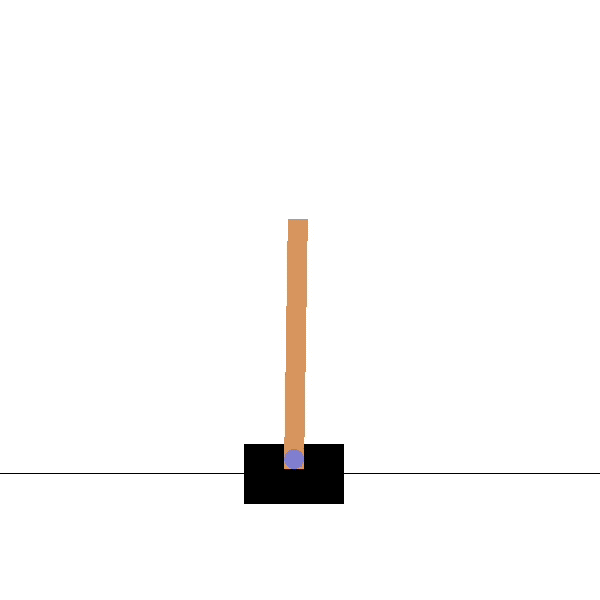

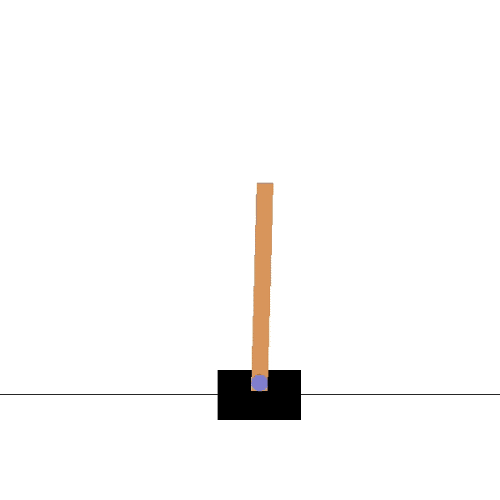

In [ ]:
#Chơi thử
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

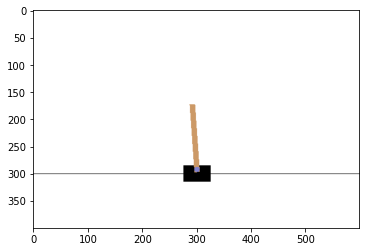

In [ ]:


env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(10):
  action = env.action_space.sample() #lấy một action bất kì tại 1 state
  obs, reward, done, info = env.step(action) #nhận các state, và reward tiếp thep
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()


In [ ]:
!pip install BOX2D

     |████████████████████████████████| 1.3MB 9.0MB/s 


In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Config parameters cho Agent
seed = 42 
gamma = 0.99  # Discount factor cho past rewward
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")  # Tạo môi trường
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [ ]:
#Tạo model
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          640         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            258         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            129         dense[0][0]                      
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
__________________________

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
          

            state = tf.convert_to_tensor(state) #convert numpy sang tf
            state = tf.expand_dims(state, 0)

            # Dự đoán phân bố xác suất action và ước lượng các rewards tương lai
            action_probs, critic_value = model(state) 
            critic_value_history.append(critic_value[0, 0]) 

            # Lấy mẫu action từ phân phối xác suất huấn luyện được
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # đưa mẫu action vừa có được vào môi trường
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Kiểm tra running rewward và reward tương lai
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Tính expected value từ rewards
        # - tại mỗi timestep running reward là tổng reward nhận được sau bước timestep này
        # - Rewards trong quá khứ là discounted nhân với gamma
        # - Đây là groud-truth cho crictic 
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Tính toán các giá trị loss để update model
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # Tại một điểm trong history, crictic sẽ ước lượng  chúng ta sẽ tính dược diff(Đây là Advantage theo như công thức ở trên)
            # Sau đó nhân với log xác suất của hành động mà ta đã chọn
            # Actor bắt buộc phải được updated do đó sau đó thông qua các step, nó sẽ dự đoán được các hành động đêm lại policy tốt nhất
            diff = value -ret
            actor_losses.append(log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Xóa loss và reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Điều kiện để dừng huấn luyện
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 14.54 at episode 10
running reward: 26.50 at episode 20
running reward: 32.74 at episode 30
running reward: 38.61 at episode 40
running reward: 44.51 at episode 50
running reward: 48.66 at episode 60
running reward: 53.78 at episode 70
running reward: 62.08 at episode 80
running reward: 79.96 at episode 90
running reward: 87.47 at episode 100
running reward: 122.57 at episode 110
running reward: 115.94 at episode 120
running reward: 110.10 at episode 130
running reward: 108.03 at episode 140
running reward: 111.31 at episode 150
running reward: 110.20 at episode 160
running reward: 107.17 at episode 170
running reward: 124.77 at episode 180
running reward: 146.72 at episode 190
running reward: 109.60 at episode 200
running reward: 79.78 at episode 210
running reward: 58.04 at episode 220
running reward: 51.18 at episode 230
running reward: 49.98 at episode 240
running reward: 50.32 at episode 250
running reward: 74.61 at episode 260
running reward: 113.00 at episode 270

#Bài tập 
tìm hiểu code trên và huấn luyện, sau đó render thử ra 10 episodes xem Agent chơi như thế nào

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1


In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:


env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(10):
  state=env.reset()
  score=0
  print("episode ",i)
  while True:
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_probs, _= model(state)

    action = np.random.choice(num_actions, p=np.squeeze(action_probs))

    state_, reward, done, info = env.step(action)
    score += reward
    state = state_
    screen = env.render(mode='rgb_array')
  
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    print(score)

    if done or score>185:
      break
    
ipythondisplay.clear_output(wait=True)
env.close()

